In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys

import py4DSTEM

#### Download raw data

In [ ]:
downloaddata = False # Set to True if you wish to download the data directly from this notebook.

if downloaddata:
    !wget -O raw_data/res36mrad_10.0us_512rpx_96qpx.h5 https://services.phaidra.univie.ac.at/api/object/o:2118784/download
    !wget -O raw_data/res109mrad_100us_256rpx_192qpx.h5 https://services.phaidra.univie.ac.at/api/object/o:2118785/download
    !wget -O raw_data/res36mrad_33.3us_512rpx_192qpx.h5 https://services.phaidra.univie.ac.at/api/object/o:2118771/download

## Defining helper functions

In [ ]:
# Load original Nion Swift data files or py4DSTEM .h5 files.
def load_data(data_path):

    import copy
    from pathlib import Path

    from py4DSTEM.io import (
        save,
        read
    )
    
    import json
    import h5py

    filetype = str(os.path.splitext(data_path)[1])
    
    if filetype == '.ndata1' or filetype == '.ndata':
        data = np.load(data_path)
        metadata = json.loads(data['metadata.json'])

        return data['data'], metadata
    
    elif filetype == '.h5':
        try:
            data = read(data_path, data_id=0)
            return data, None
        except:
            file = h5py.File(data_path, 'r')
            data = file['data'][:]
            metadata = json.loads(file['data'].attrs['properties'])
            file.close()
            return data, metadata
        
    elif filetype =='.dm3' or filetype =='.dm4':
        vacuum_probe = ncemio.read(data_path)["data"]
        
        return data, None

In [ ]:
# Load metadata from a file without loading the data.
def load_metadata(data_path, filetype):
    import json
    
    if filetype == '.ndata':
        data = np.load(data_path)
        metadata = json.loads(data['metadata.json'])
        
        return metadata, data['data'].shape

    elif filetype == '.h5':
        import h5py
        file = h5py.File(data_path, 'r')
        shape = file['data'].shape
        metadata = json.loads(file['data'].attrs['properties'])
        file.close()
        
        return metadata, shape

In [ ]:
# Print metadata from a file without loading the data.
# fov = field of view in Å; rpx = scan size in scan size in pixels; qpix = diffraction pattern size in pixels.
def print_metadata(folder, filetype, fov, rpix, qpix, print_all=False):
    import pathlib
    dir = pathlib.Path(folder)
    files = dir.rglob("*" + filetype)
    for path in list(files):
        if 'trash' in str(path):
            continue
        me, shape = load_metadata(path, filetype)
        try:
            scan = me['metadata']['scan']
            try:
                hws = me['metadata']['hardware_source']
                if print_all:
                    print("\n" + str(path))
                    print("Field of view: " + str(scan['fov_nm']*10) + " A.")
                    print("Scan pixels: " + str(me['metadata']['scan']['scan_size']))
                    print("CBED pixels: " + str(shape[2:]))
                    print("Dwell time: " + str(round(hws['detector_configuration']['frame_time']*1e6,1)))
                elif int(scan['fov_nm']*10) == int(fov) and int(rpix) == me['metadata']['scan']['scan_size'][0] and shape[2:][0] == qpix:
                    print("\n" + str(path))
                    print("Field of view: " + str(scan['fov_nm']*10) + " A.")
                    print("Scan pixels: " + str(me['metadata']['scan']['scan_size']))
                    print("CBED pixels: " + str(shape[2:]))#hws['detector_configuration']['x_pixels_in_detector']))
                    print("Dwell time: " + str(round(hws['detector_configuration']['frame_time']*1e6,1)))
            except KeyError:
                print("\n" + str(path))
                print("Data shape: " + str(me['data_shape']))
                continue
        except KeyError:
            print("\n" + str(path))
            print(str(shape))
            #print("Single CBED.")

In [ ]:
# Load Nion Swift metadata, and load and bin data in R and Q, 
# apply py4DSTEM calibrations based on the metadata, 
# and return the DataCube and metadata objects.
# Does not normalize counts by default.
def loadbinmetadata(datapath, binQ=1, thinR=1, plot_output=False, countnormalize=False):
    from py4DSTEM import DataCube
    
    data, me = load_data(datapath)
    dc = DataCube(data)
    del data
    
    if countnormalize:
        normalize_counts(dc)
    
    raw_mean_dp = dc.get_dp_mean()

    if thinR != 1:
        dc = dc.bin_R(thinR)
    if binQ != 1:
        dc = dc.bin_Q(binQ)

    probe_px_size, qx0, qy0 = dc.get_probe_size()

    # Read out the spherical aberration coefficient and field of view.
    #Cs = me['metadata']['instrument']['ImageScanned']['C30']
    fov = me['metadata']['scan']['fov_nm'] * 10
    
    # Read in the high tension and scan step.
    scanpix = me['metadata']['scan']['scan_size']
    dwelltime = me['metadata']['hardware_source']['detector_configuration']['frame_time']*1e6 # in microseconds
    scanstep = fov / scanpix[0]
    E = me['metadata']['instrument']['high_tension']
    k_pix = me['metadata']['hardware_source']['detector_configuration']['x_pixels_in_detector']
   
    # Read in the probe convergence semiangle in radians
    probe_rad_angle = me['metadata']['instrument']['ImageScanned']['probe_ha']
   
    lam = py4DSTEM.process.utils.electron_wavelength_angstrom(E) #py4DSTEM function for calculating lambda from E
    
    k_probe = py4DSTEM.process.calibration.get_Q_pixel_size(probe_px_size, probe_rad_angle / lam)
    
    reciprocal_space_sampling_invang  = k_probe[0] / 2
    reciprocal_space_sampling_rad    = (lam*reciprocal_space_sampling_invang,) * 2
    
    probe_rad_fitted = reciprocal_space_sampling_rad[0] * probe_px_size
    
    dc.calibration.set_R_pixel_size(scanstep)
    dc.calibration.set_R_pixel_units('A')
    dc.calibration.set_Q_pixel_size(reciprocal_space_sampling_invang)
    dc.calibration.set_Q_pixel_units('A^-1')
    dc.calibration.set_convergence_semiangle_mrad(probe_rad_fitted*1e3)

    if plot_output:
        print('Estimated (binned) probe radius =', '%.2f' % probe_px_size, 'pixels')
        print("Field of view = ", fov, " A")
         
        print("Scan step = ", scanstep, " Å")
        print("High tension = ", E, " V")

        print("Nominal probe convergence semiangle: ", probe_rad_angle*1000, " mrad.")

        print("Reciprocal space pixel size = ", reciprocal_space_sampling_invang, " A^-1")
        print("Sanity check: size of probe = ", probe_rad_fitted * 1e3, " mrad.")
    
        py4DSTEM.show(raw_mean_dp, ticks=False, scaling='log', cmap='turbo', title='Unbinned data (log scale)')
    
    return dc, me

In [ ]:
# Normalize the counts of each diffraction pattern to the average number of counts in the entire 4D dataset.
def normalize_counts(dc, plot_output=False):

    counts = dc.data.sum(axis=(2,3))
    
    ave_counts = np.mean(counts)
    std_counts = np.std(counts)
    
    data_normed = np.einsum('ijkl,ij->ijkl', dc.data[:,:], 1/counts) * ave_counts
    dc.data = data_normed
    if plot_output:
        print("Total number of counts per diffraction pattern normalized to average: " + str(ave_counts))

In [ ]:
# Calculate a virtual annular dark-field image from a given DataCube.

def virtual_adf(dc, intermediate_outputs=False, plot_output=False):
    import py4DSTEM
    
    probe_semiangle, probe_qx0, probe_qy0 = dc.get_probe_size(dc.get_dp_mean().data)
    
    # set the geometry
    center = (probe_qx0, probe_qy0)
    r_inner = probe_semiangle * 1.1 # Inner radius slightly outside BF-disk.
    r_outer = probe_semiangle * 5 # Outer radius "big enough"
    radii = (r_inner,r_outer)

    if intermediate_outputs:
        dc.position_detector(
            mode = 'annular',
            geometry = (center,radii)
        )
    
    dc.get_virtual_image(
        mode = 'annular',
        geometry = (center,radii),
        name = 'dark_field',
        returncalc = False,
        verbose = intermediate_outputs,
    );

    if plot_output:
        py4DSTEM.show(
            dc.tree('dark_field'),
            ticks=False,
        )
        plt.show(block=False)
        
    return dc.tree('dark_field').data

In [ ]:
# Count the dose from a 4D dataset with corrections for quantum efficiency and live count time fraction.

def estimate_dose(dc, me, plot_output=False):
    counts_per_electron = 0.85 # DQE(0) for the Dectris ARINA detector at 60 keV.
    # Estimate the areal dose by summing up the counts of the DE camera.
    totalcounts = np.sum(dc.data)
    
    frames = 1
        
    count_time = me['metadata']['hardware_source']['detector_configuration']['count_time'] 
    frame_time = me['metadata']['hardware_source']['detector_configuration']['frame_time']
    live_fraction = count_time / frame_time
    
    totaldose = totalcounts / live_fraction / counts_per_electron
    arealdose = totaldose / (me['metadata']['scan']['fov_nm']*10)**2

    if plot_output:
        print("Total dose (corrected) = ", totaldose * frames, " e-")
        print("Areal dose (corrected) = ", arealdose * frames, " e-/Å^2")

In [ ]:
# Plot the time variation of the electron dose from a 4D dataset.
# Note that this only makes sense to plot before dose normalization.

def plot_time_variation(dc, m, avestep=10000, mode='electrons'):

    from scipy.ndimage import uniform_filter1d
    counts_per_electron = 0.85 # DQE(0) for the Dectris ARINA detector at 60 keV.

    count_time = m['metadata']['hardware_source']['detector_configuration']['count_time'] 
    frame_time = m['metadata']['hardware_source']['detector_configuration']['frame_time']
    live_fraction = count_time / frame_time

    dwell_time = dwelltime = m['metadata']['hardware_source']['detector_configuration']['frame_time']*1e6 # in microseconds
    
    # Calculate time-variation of dose
    counts = dc.data.sum(axis=(2,3))
    dosetime = counts.flatten() / live_fraction / counts_per_electron
    ave = np.mean(dosetime)
    std = np.std(dosetime)
    
    dosetimeaveraged = uniform_filter1d(dosetime, size = avestep)

    timestep = np.round(dwelltime)
    t = np.arange(0, len(dosetime)*timestep, timestep) * 1e-6

    eperpA = 6.242e6
    
    fig, (ax1, ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios': [3, 1]})
    
    ax2.set_yticks([]) 
    ax2.set_xticks([]) 
    
    if mode == 'electrons':
        
        ax1.plot(t, dosetime, 'k', linewidth=0.02)
        ax1.plot(t, dosetimeaveraged, 'r', linewidth=1)
        ax1.set_ylabel("Electrons");
        ax1.set_xlabel("Seconds");
        
        ax2.hist(dosetime, bins=100, orientation="horizontal", 
             histtype='step', color='k',
             linewidth=0.5);
    
        maxval = np.histogram(dosetime, bins=100)[0].max()
        stdheight = maxval / np.exp(1/2)
    
        ax2.errorbar(stdheight, ave, yerr=std, color='r',
                     capsize=5, elinewidth=1.5, markeredgewidth=1.5)
        ax2.text(stdheight, ave, str(np.round(std/ave*100,2))+"%",
                 ha='right', va='center', size=11, color='r'
                 )
    
        plt.tight_layout()
        #plt.savefig("electrons_timevariation.pdf", dpi = 600)
    
    if mode == 'current':
    
        ax1.plot(t, dosetime / eperpA /frame_time, 'k', linewidth=0.02)
        ax1.plot(t, dosetimeaveraged / eperpA /frame_time, 'r', linewidth=1)
        ax1.set_ylabel("Current (pA)");
        ax1.set_xlabel("Seconds");
        
        ax2.hist(dosetime / eperpA /frame_time, bins=100, orientation="horizontal", 
             histtype='step', color='k',
             linewidth=0.5);
    
        maxval = np.histogram(dosetime / eperpA /frame_time, bins=100)[0].max()
        stdheight = maxval / np.exp(1/2)
    
        ax2.errorbar(stdheight, ave / eperpA /frame_time, yerr=std / eperpA /frame_time, color='r',
                     capsize=5, elinewidth=1.5, markeredgewidth=1.5)
        ax2.text(stdheight, ave / eperpA /frame_time, str(np.round(std/ave*100,2))+"%",
                 ha='right', va='center', size=11, color='r'
                 )
    
        plt.tight_layout()
        plt.savefig("current_timevariation.pdf", dpi = 600)

In [ ]:
# Plot the space variation of the electron dose over the scan field of view from a 4D dataset.
# Note that this only makes sense to plot before dose normalization.

def plot_space_variation(dc, me):
    
    counts_per_electron = 0.85 # DQE(0) for the Dectris ARINA detector at 60 keV.
     
    fov = me['metadata']['scan']['fov_nm'] * 10
    
    count_time = me['metadata']['hardware_source']['detector_configuration']['count_time'] 
    frame_time = me['metadata']['hardware_source']['detector_configuration']['frame_time']
    live_fraction = count_time / frame_time

    dwell_time = dwelltime = me['metadata']['hardware_source']['detector_configuration']['frame_time']*1e6 # in microseconds
    
    # Calculate time-variation of dose
    counts = dc.data.sum(axis=(2,3))
    dosemap = counts / live_fraction / counts_per_electron

    fig, ax = plt.subplots(1,1)
    im = ax.imshow(dosemap, extent=(0, fov, 0, fov))
    ax.set_title('Dose variation')
    cbar = fig.colorbar(im,ax=ax)
    cbar.set_ticks([])
    ax.set_xlabel("x (Å)")
    ax.set_ylabel("y (Å)")
    #plt.show(fig)
    plt.savefig("current_spacevariation.pdf", dpi = 600)
    
    return fig, ax

In [ ]:
# Iterative differential phase contrast reconstruction of the phase, equivalent to iCOM.
# If a path is given for `write_dc`, adds the Q-R rotation angle into the DataCube file on disk.

def return_icom(dc, me, intermediate_outputs=False, plot_output=False, return_object=False, write_dc=''):
    
    from py4DSTEM.process.phase import DPC

    try:
        E = me['metadata']['instrument']['high_tension']
    except KeyError:
        E = me['energy']
    
    dpc = DPC(
        dc,
        device='cpu',
        energy=E,
        verbose=intermediate_outputs,
    ).preprocess(
        maximize_divergence=False,
        figsize=(6,6),
        cmap='PiYG',
        plot_rotation = False,
        plot_center_of_mass = False,
        #progress_bar=intermediate_outputs,
    )
    
    # DPC CoM signals are typically noisy, and a much more reliable angle is detected when blurring.
    from scipy.ndimage import gaussian_filter

    blurradius=4

    if intermediate_outputs:
        print("Applying a Gaussian blur of " + str(blurradius) + " px to COM signals and redoing.")
    
    com_x_filtered = gaussian_filter(dpc._com_measured_x, blurradius)
    com_y_filtered = gaussian_filter(dpc._com_measured_y, blurradius)
    
    dpc = DPC(
        dc,
        device='cpu',
        energy=E,
        verbose=intermediate_outputs,
    ).preprocess(
        maximize_divergence=False,
        figsize=(6,6),
        cmap='PiYG',
        force_com_measured = (com_x_filtered, com_y_filtered),
        plot_rotation = intermediate_outputs,
        plot_center_of_mass = intermediate_outputs,
        #progress_bar=intermediate_outputs,
    )
    
    rotation = dpc._rotation_best_rad * 180 / np.pi
    dc.calibration.set_QR_rotation_degrees(rotation)
    
    if write_dc != '':
        py4DSTEM.save(write_dc + '.h5', dc, 'o')
        
    icom = dpc.reconstruct(
        progress_bar=intermediate_outputs,
        store_iterations=False,
        max_iter=20,
        reset=True,
        #q_highpass = 0.2,
    )

    if intermediate_outputs:
        dpc.visualize(cbar=True);

    if plot_output:
        fig, ax = plt.subplots()
        try:
            fov = me['metadata']['scan']['fov_nm'] * 10
            im1 = ax.imshow(dpc.object_phase, extent=(0, fov, 0, fov), interpolation='none')
        except KeyError:
            fov = me['fov']
            im1 = ax.imshow(dpc.object_phase, extent=(0, fov[0], 0, fov[1]), interpolation='none')
        
        ax.set_title('iCoM phase (py4DSTEM)')
        ax.set_xlabel('x (Å)')
        ax.set_ylabel('y (Å)')
        fig.colorbar(im1,ax=ax)
        plt.show(fig, block=False)
    
    if return_object:
        return icom
    else:
        return icom.object_phase * 2*np.pi # Correction factor to match the phase magnitudes of other ptycho methods.

In [ ]:
# Single-sideband (SSB) and Wigner distribution deconvolution (WDD) phase reconstructions using the py4DSTEM code.
# Used by default in the following analyses. Note: upon writing this is on the dev branch of the code!

def return_ssb(dc, me, fit_aberrations=False, intermediate_outputs=False, plot_output=False, return_object=False):

    try:
        U = me['metadata']['instrument']['high_tension']
    except KeyError:
        U = me['energy']

    ptycho = py4DSTEM.process.phase.SSB(
        energy=U,
        datacube=dc,
        semiangle_cutoff=dc.calibration['convergence_semiangle_mrad'],
        verbose=intermediate_outputs,
    ).preprocess(
        plot_center_of_mass=intermediate_outputs,
        plot_rotation=intermediate_outputs,
        plot_overlap_trotters=intermediate_outputs,
        force_com_rotation=dc.calibration['QR_rotation_degrees'],
        force_com_transpose = False,
        vectorized_com_calculation=False,
        crop_around_bf_disk=True,
    )
        
    if fit_aberrations:
        ptycho.aberration_fit(
            num_trotters=5,
            max_radial_order=6,
            method='recursive',
            plot_fitted_fourier_probe=intermediate_outputs,
        )
    
    ptycho.reconstruct(
        phase_compensation=fit_aberrations,
    )

    if plot_output:
        ptycho.visualize()
        
    if return_object:
        return ptycho.object
    else:
        return ptycho.object.imag

# For WDD, we use a Wiener epsilon value of 1 by default for converged phase values.
def return_wdd(dc, me, fit_aberrations=False, relative_wiener_epsilon=1, intermediate_outputs = False, plot_output=False, return_object=False):

    try:
        U = me['metadata']['instrument']['high_tension']
    except KeyError:
        U = me['energy']

    ptycho = py4DSTEM.process.phase.WDD(
        energy=U,
        datacube=dc,
        semiangle_cutoff=dc.calibration['convergence_semiangle_mrad'],
        verbose=intermediate_outputs,
    ).preprocess(
        plot_center_of_mass=intermediate_outputs,
        plot_rotation=intermediate_outputs,
        plot_overlap_trotters=intermediate_outputs,
        force_com_rotation=dc.calibration['QR_rotation_degrees'],
        force_com_transpose=False,
        vectorized_com_calculation=False,
        crop_around_bf_disk=True,
    )
    
    if fit_aberrations:
        ptycho.aberration_fit(
            num_trotters=5,
            max_radial_order=6,
            method='recursive',
            plot_fitted_fourier_probe=intermediate_outputs,
        )

    ptycho.reconstruct(relative_wiener_epsilon=relative_wiener_epsilon)
        
    if plot_output:
        ptycho.visualize()
    
    return ptycho.object.imag

In [ ]:
# Parallax (aka tilt-corrected BF-STEM) phase reconstruction using py4DSTEM.
# For focused-probe data of a weakly scattering object with almost no bright-field contrast,
# iterating the alignments only once or at most a few times produces the best results.

def return_parallax(dc, me, iterations=1, intermediate_outputs=False, plot_output=False):

    try:
        U = me['metadata']['instrument']['high_tension']
    except KeyError:
        U = me['energy']
    
    parallax = py4DSTEM.process.phase.Parallax(
        datacube = dc,
        energy = U,
        object_padding_px = (12,12),
        device = "cpu",
        defocus = 0, # For focused-probe data.
        verbose = intermediate_outputs,
    ).preprocess(
        plot_average_bf=intermediate_outputs,
        edge_blend=8,
        threshold_intensity=0.65,
        force_rotation_angle_deg = dc.calibration['QR_rotation_degrees'],
        vectorized_com_calculation = False,
        #normalize_images = False,
    )

    parallax = parallax.reconstruct(
        reset=True,
        progress_bar = intermediate_outputs,
        #regularize_shifts=False,
        #running_average=False,
        alignment_bin_values=[32]*iterations,
        plot_aligned_bf = intermediate_outputs,
        plot_convergence = intermediate_outputs,
    )

    if intermediate_outputs:
        parallax.show_shifts()

    if intermediate_outputs == False:
        import warnings
        warnings.filterwarnings('ignore')
    
    parallax.subpixel_alignment(
        plot_upsampled_BF_comparison=intermediate_outputs,
        plot_upsampled_FFT_comparison=intermediate_outputs,
    )
    
    parallax.aberration_fit(
        plot_CTF_comparison=intermediate_outputs,
        force_rotation_angle_deg = dc.calibration['QR_rotation_degrees'],
    )
    
    parallax.aberration_correct(
        use_CTF_fit=True,
        plot_corrected_phase=plot_output,
    )
    
    return parallax.object_cropped

In [ ]:
# Iterative single-slice ptychography phase reconstruction using gradient-descent in py4DSTEM.
def return_iterGD(dc, me, probe=None, defocus=0, rotation=0, batchsize=512, paddingfactor=1, intermediate_outputs = False, plot_output=False):
        
    try:
        U = me['metadata']['instrument']['high_tension']
    except KeyError:
        U = me['energy']
        
    ptycho = py4DSTEM.process.phase.SingleslicePtychography(
        datacube=dc,
        verbose=intermediate_outputs,
        energy=U,
        semiangle_cutoff=dc.calibration['convergence_semiangle_mrad'],
        object_type='potential',
        defocus = defocus, # Defocus guess; here better to use zero
        object_padding_px = (12,12),
        clear_fft_cache=True, #saves memory
        device='gpu',
        storage='cpu',
        vacuum_probe_intensity=probe,
        )
    
    ptycho = ptycho.preprocess(
                plot_center_of_mass = intermediate_outputs,
                plot_probe_overlaps = intermediate_outputs,
                force_com_rotation = rotation,
                force_com_transpose = False,
                vectorized_com_calculation = False,        
                max_batch_size=batchsize, # Maximum possible within memory limit is usually good
                padded_diffraction_intensities_shape = tuple(np.dot(dc.shape[-2:],paddingfactor)),
    )

    ptycho = ptycho.reconstruct(
        reset=True,
        progress_bar = intermediate_outputs,
        store_iterations = True,
        num_iter = 15,
        object_positivity=False,
        #step_size = 0.2,
        #normalization_min = 0.1,
        #gaussian_filter_sigma = 0.2, # in A
        #q_highpass = 0.2,
        max_batch_size=batchsize, # Maximum possible within memory limit is usually good
        device='gpu',
    )
    
    if intermediate_outputs:
        
        ptycho.visualize(iterations_grid='auto')
    
    if plot_output:
        obj = ptycho.object_cropped
        fig, ax = plt.subplots(1,1)
        
        try:
            fov = me['metadata']['scan']['fov_nm'] * 10
            im = ax.imshow(obj, extent=(0, fov, 0, fov), interpolation='none')
        except:
            fov = me['fov']
            im = ax.imshow(obj, extent=(0, fov[0], 0, fov[1]), interpolation='none')
            
        ax.set_title('Iterative GD phase (py4DSTEM)')
        ax.set_xlabel('x (Å)')
        ax.set_ylabel('y (Å)')
        fig.colorbar(im,ax=ax)
        plt.show(fig, block=False)
        
    return ptycho.object_cropped

In [ ]:
def image_histogram_equalization(image, number_bins=512):
    # from http://www.janeriksolem.net/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = (number_bins-1) * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)

In [ ]:
# Run all analyses, return reconstructed phase images and the time required for each.

def run_all(dc, me, probe, ang, qpix, binQ, thinR, intermediate_outputs=False, plot_output=False, normalize=False, savefiles=False):

    import time
    
    adf = virtual_adf(dc, intermediate_outputs, plot_output)
    
    if intermediate_outputs:
        plot_time_variation(dc, me)

    if normalize:
        normalize_counts(dc)

    t1 = time.perf_counter()
    icom = return_icom(dc, me, intermediate_outputs, plot_output)
    t2 = time.perf_counter()
    ticom = (t2-t1)
    
    # Setting the number of alignment iterations to optimal values depending on data.
    if ang == 36 and qpix == 192:
        if binQ <=4:
            iterations = 1
            if thinR == 2:
                iterations = 3
        elif binQ == 8:
            iterations = 5
        elif binQ == 16:
            iterations = 2
            if thinR == 8:
                iterations = 5
        elif binQ == 32:
            iterations = 10
    elif ang == 109:
        if binQ == 8:
            iterations = 3
        elif binQ == 4:
            iterations = 6
        elif binQ == 2:
            iterations = 4
        else:
            iterations = 3
    elif qpix == 96:
        if binQ == 16:
            iterations = 9
    else:
        iterations = 1
    
    print("Parallax iterations set to the optimized value of ", str(iterations), ".")

    # Avoids running parallax for data sizes that do not fit in memory.
    if ang == 36:
        if (qpix == 192 and binQ <= 2 and thinR == 1):
            print("Skipping parallax due to memory limitation.")
            tpar = 0
            parallax = np.zeros((512,512))
        elif (qpix == 96 and binQ == 1):
            print("Skipping parallax due to memory limitation.")
            tpar = 0
            parallax = np.zeros((512,512))
        elif thinR == 16:
            print("Skipping parallax due to insufficient data.")
            tpar = 0
            parallax = np.zeros((512,512))
        else:
            t1 = time.perf_counter()
            parallax = return_parallax(dc, me, iterations,
                                   intermediate_outputs, plot_output)
            t2 = time.perf_counter()
            tpar = (t2-t1)
    if ang == 109:
        t1 = time.perf_counter()
        parallax = return_parallax(dc, me, iterations,
                               intermediate_outputs, plot_output)
        t2 = time.perf_counter()
        tpar = (t2-t1)
    
    # Avoids running direct ptychography for data sizes that do not fit in memory.
    if ang == 36 and qpix == 192 and binQ == 1:
        print('Skipping direct ptychography due to memory limitation.')
        tssb = 0
        tssb_ac = 0
        twdd = 0
        twdd_ac = 0
        
        ssb = np.zeros((512,512))
        ssb_ac = np.zeros((512,512))
        wdd = np.zeros((512,512))
        wdd_ac = np.zeros((512,512))
    else:    
        t1 = time.perf_counter()
        ssb = return_ssb(dc, me, False, plot_output)
        t2 = time.perf_counter()
        tssb = (t2-t1)

        t1 = time.perf_counter()
        ssb_ac = return_ssb(dc, me, True, plot_output)
        t2 = time.perf_counter()
        tssb_ac = (t2-t1)

        t1 = time.perf_counter()
        wdd = return_wdd(dc, me, False, 1, intermediate_outputs, plot_output)
        t2 = time.perf_counter()
        twdd = (t2-t1)

        t1 = time.perf_counter()
        wdd_ac = return_wdd(dc, me, True, 1, intermediate_outputs, plot_output)
        t2 = time.perf_counter()
        twdd_ac = (t2-t1)

    # Q-space padding factor for iterative ptycho: 3 for 36 mrad data, except 2 for binQ=2 and 1 for binQ=1; 1 for 109 mrad.
    if ang == 109:
        paddingfactor = 1
    
    elif ang == 36:
        if qpix == 192 and binQ == 1:
            paddingfactor = 1
        elif (qpix == 192 and binQ == 2):
            paddingfactor = 2
        elif (qpix == 96 and binQ == 1):
            paddingfactor = 2
        elif (qpix == 192 and thinR != 1):
            paddingfactor = 3
        else:
            paddingfactor = 3
            
    t1 = time.perf_counter()
    iterGD = return_iterGD(dc, me, probe, 0, # zero defocus 
                           dc.calibration['QR_rotation_degrees'], 512, 
                           paddingfactor,
                           intermediate_outputs, plot_output)
    t2 = time.perf_counter()
    titerGD = (t2-t1)
    
    return {'adf':adf, 'icom':icom, 'parallax':parallax, 'iterGD':iterGD, 'ssb':ssb, 'ssb_ac':ssb_ac, 'wdd':wdd, 'wdd_ac':wdd_ac},\
           [ticom, tpar, titerGD, tssb, tssb_ac, twdd, twdd_ac]

In [ ]:
# Plotting the results loaded from a Numpy .npy file saved to disk.

def makeplots(me, res, path, savefig = False):

    vmin = -0.015
    vmax = 0.015
    
    plt.rcParams.update({'font.size': 12})
    fig, ax = plt.subplots(2, 4, figsize=(20,9), gridspec_kw={'width_ratios': [1, 1, 1, 1], 'wspace':-0.2})

    fov = me['metadata']['scan']['fov_nm'] * 10
    
    for axis in ax.ravel():
        axis.set_axis_off()
        axis.set_xticklabels([])
        axis.set_yticklabels([])
    
    normedadf = image_histogram_equalization(res['adf'])
    
    im00 = ax[0,0].imshow(normedadf,
                      extent=(0, fov, 0, fov), interpolation='none', 
                      cmap='gray',
                      vmax=np.max(normedadf)*1.2,
                      origin='lower', 
                     )
    ax[0,0].set_title('a) Virtual ADF intensity')

    im02 = ax[0,1].imshow(res['icom'], extent=(0, fov, 0, fov), interpolation='none', vmin=vmin, vmax=vmax, origin='lower')
    ax[0,1].set_title('b) iCOM phase')
    
    im03 = ax[0,2].imshow(res['parallax'], extent=(0, fov, 0, fov), interpolation='none', vmin=vmin, vmax=vmax, origin='lower')
    ax[0,2].set_title('c) Parallax phase')
    
    im04 = ax[0,3].imshow(res['iterGD'], extent=(0, fov, 0, fov), interpolation='none', vmin=vmin, vmax=vmax, origin='lower')
    ax[0,3].set_title('d) Iterative GD phase')

    im10 = ax[1,0].imshow(res['ssb'], extent=(0, fov, 0, fov), interpolation='none', vmin=vmin, vmax=vmax, origin='lower')
    ax[1,0].set_title('e) SSB phase')
    
    im12 = ax[1,1].imshow(res['ssb_ac'], extent=(0, fov, 0, fov), interpolation='none', vmin=vmin, vmax=vmax, origin='lower')
    ax[1,1].set_title('f) SSB phase (AC)');

    im13 = ax[1,2].imshow(res['wdd'], extent=(0, fov, 0, fov), interpolation='none', vmin=vmin, vmax=vmax, origin='lower')
    ax[1,2].set_title('g) WDD phase');
    
    im14 = ax[1,3].imshow(res['wdd_ac'], extent=(0, fov, 0, fov), interpolation='none', vmin=vmin, vmax=vmax, origin='lower')
    ax[1,3].set_title('h) WDD phase (AC)');

    #plt.show()
    if savefig:
        plt.savefig(path + "_ptycho.pdf", dpi=300, bbox_inches = 'tight', pad_inches = 0)

## Run all analyses

In [ ]:
# Give the directory to your folder.
dire = "/home/jupyter-toma/git/arina-ptycho/"

In [ ]:
# Raw data is loaded directly as datacubes, otherwise binning in Q or thinning in R is applied.
def loadbindata(dire, rawname, ang, binQ=1, thinR=1):
    
    import json
    
    try:
        probe = np.load(dire + "vacuum_probes/" + str(ang) + "mrad_probe.npy")
    except:
        probe = None

    datapath = dire + "raw_data/" + rawname
    
    dc = py4DSTEM.read(datapath + '.h5')
    
    if binQ != 1 or thinR !=1:
        if thinR != 1:
            dc = dc.bin_R(thinR)
        if binQ != 1:
            dc = dc.bin_Q(binQ)
              
    me = json.load(open(datapath + '.json'))
    
    return dc, me, probe

In [ ]:
# Raw data is loaded directly as datacubes, otherwise binning in Q or thinning in R is applied.
def runandsave(dire, name, dc, me, probe, ang, qpix, binQ, thinR, show_intermediate_outputs=False, plot_output=True, savefiles=False):
    
    res, times = run_all(dc, me, probe, ang, qpix, binQ, thinR, show_intermediate_outputs, plot_output)
    
    if savefiles:
        np.savez(dire + "results/" + name + ".npz", adf=res['adf'],
                 icom=res['icom'], parallax=res['parallax'], iterGD=res['iterGD'], 
                 ssb=res['ssb'], ssb_ac=res['ssb_ac'], 
                 wdd=res['wdd'], wdd_ac=res['wdd_ac'])
        np.savetxt(dire + "results/" + name + ".txt", times)
    
    return me, res, times

In [ ]:
def loadresults(dire, name, rawname):

    import json
    import numpy as np

    path = dire + "results/" + name
    rawpath = dire + "raw_data/" + rawname
    
    me = json.load(open(rawpath + '.json'))
        
    res = np.load(path + ".npz", allow_pickle=True)
    times = np.loadtxt(path + ".txt")

    return me, res, times

In [ ]:
def plotresults(me, res, savepath, savefig=False):

    makeplots(me=me, res=res, path=savepath, savefig=savefig)

#### Run analyses on all data

In [ ]:
# Maximum frame rate of the ARINA (using 2x hardware binning in Q).

dt = 10.0
ang = 36
thinR = 1
rpix = 512
qpix = 96

for binQ in [1, 2, 4, 8, 16]: 
    rawname = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_" + str(qpix) + "qpx"
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)

    dc, me, probe = loadbindata(dire, rawname, ang, binQ, thinR)
    me, res, times = runandsave(dire, name, dc, me, probe, ang, qpix, binQ, thinR, show_intermediate_outputs=False, plot_output=True, savefiles=True)
    makeplots(me, res, dire, True)

In [ ]:
# Full ARINA sensor (192x192 Q-pixels).

dt = 33.3
ang = 36
thinR = 1
rpix = 512
qpix = 192

for binQ in [1, 2, 4, 8, 16, 32]:
    rawname = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_" + str(qpix) + "qpx"
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)

    dc, me, probe = loadbindata(dire, rawname, ang, binQ, thinR)
    
    me, res, times = runandsave(dire, name, dc, me, probe, ang, qpix, binQ, thinR, show_intermediate_outputs=False, plot_output=True, savefiles=True)
    makeplots(me, res, dire)

In [ ]:
# For different thinnings of the real-space scan grid (thinR) for a binned full sensor.

dt = 33.3
ang = 36
binQ = 16
rpix = 512
qpix = 192

for thinR in [2, 4, 8]: # 16 kinda works for direct ptycho, but not for parallax or iterative GD
    rawname = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_" + str(qpix) + "qpx"
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)

    dc, me, probe = loadbindata(dire, rawname, ang, binQ, thinR)
    me, res, times = runandsave(dire, name, dc, me, probe, ang, qpix, binQ, thinR, show_intermediate_outputs=False, plot_output=True, savefiles=True)
    makeplots(me, res, dire)

In [ ]:
# A longer camera length capturing scattering angles up to 109 mrad on the unbinned sensor.

dt = 100
ang = 109
thinR = 1
rpix = 256
qpix = 192

for binQ in [1,2,4,8]: # 16 otherwise kinda works but parallax produces unphysical phases
    rawname = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_" + str(qpix) + "qpx"
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)

    dc, me, probe = loadbindata(dire, rawname, ang, binQ, thinR)
    me, res, times = runandsave(dire, name, dc, me, probe, ang, qpix, binQ, thinR, show_intermediate_outputs=False, plot_output=False, savefiles=True)
    makeplots(me, res, dire, True)

#### Effect of the WDD epsilon parameter

In [ ]:
import json
# Effect of the WDD epsilon parameter on the phase values.

dt = 10.0
ang = 36
binQ = 2
thinR = 1
rpix = 512
qpix = 96

rawname = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_" + str(qpix) + "qpx"
name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)

rawpath = dire + "raw_data/" + rawname
datapath = dire + "results/" + name
savepath = dire + "results/analyses/" + name + "_wdd_epsilonvariation"

recalculate = True

if recalculate:

    dc = py4DSTEM.read(rawpath + '.h5')
    dc.bin_Q(binQ)
    
    me = json.load(open(rawpath + '.json'))

    epsilons = [0.01, 0.025, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
    wdd_phases_ac = []
    
    for epsilon in epsilons:
        wdd_phases_ac.append(return_wdd(dc, me, True, epsilon))
        
    wddmaxvals_ac = np.max(wdd_phases_ac, axis=(1,2))
    
    ssbphaseimage_ac = return_ssb(dc, me, True)
    ssbmaxval_ac = np.max(ssbphaseimage_ac)
    
    np.savez(savepath + '.npz', 
             epsilons=epsilons, 
             wddmaxvals_ac=wddmaxvals_ac, 
             ssbmaxval_ac=ssbmaxval_ac)

In [ ]:
# Loading previously calculated results on the effect of the WDD epsilon parameter.
dt = 33.3
ang = 36
binQ = 4
thinR = 1
rpix = 512
qpix = 192

name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)

savepath = dire + "results/analyses/" + name + "_wdd_epsilonvariation"

datafull = np.load(savepath + '.npz')

dt = 10.0
ang = 36
binQ = 2
thinR = 1
rpix = 512
qpix = 96

name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)

savepath = dire + "results/analyses/" + name + "_wdd_epsilonvariation"

datafast = np.load(savepath + '.npz')

dt = 100
ang = 109
binQ = 1
thinR = 1
rpix = 256
qpix = 192

name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)

savepath = dire + "results/analyses/" + name + "_wdd_epsilonvariation"

datalong = np.load(savepath + '.npz')

In [ ]:
# Plotting the results on the effect of the WDD epsilon parameter on phase values.

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fig, (ax2, ax1) = plt.subplots(2, 1, figsize=(6,11))

ax1.scatter(datafull['epsilons'], datafull['wddmaxvals_ac'], label="36 mrad WDD (AC)")
ax1.scatter(datalong['epsilons'], datalong['wddmaxvals_ac'], label="109 mrad WDD (AC)")
ax1.axhline(float(datafull['ssbmaxval_ac']), linestyle='--', label="36 mrad SSB (AC)")
ax1.axhline(float(datalong['ssbmaxval_ac']), linestyle='-.', label="109 mrad SSB (AC)", color='orange',)
ax1.set_ylabel("Maximum phase value (mrad)")
ax1.set_xlabel("Wiener epsilon")
ax1.legend()
ax1.set_ylim((0,0.05))

ax2.scatter(datafull['epsilons'], datafull['wddmaxvals_ac'], label="36 mrad WDD (AC)")
ax2.scatter(datalong['epsilons'], datalong['wddmaxvals_ac'], label="109 mrad WDD (AC)")
ax2.axhline(float(datafull['ssbmaxval_ac']), linestyle='--', label="36 mrad SSB (AC)")
ax2.axhline(float(datalong['ssbmaxval_ac']), linestyle='-.', label="109 mrad SSB (AC)", color='orange',)
ax2.set_ylabel("Maximum phase value (mrad)")
ax2.set_xlabel("Wiener epsilon")
ax2.legend()
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim((2e-3,2))
            
plt.savefig(dire + "results/analyses/wdd_epsilonvariation_loglog.pdf")
plt.show()

### Make all plots

In [ ]:
savefig = True

#### 36 mrad

In [ ]:
# For different binnings of the diffraction patterns (binQ).

dt = 33.3
ang = 36
thinR = 1
rpix = 512
qpix = 192

for binQ in [1, 2, 4, 8, 16, 32]: 
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
    rawname = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_" + str(qpix) + "qpx"
    savepath = dire + "results/figures/" + name
    
    me, res, times = loadresults(dire, name, rawname)
    plotresults(me, res, savepath, savefig)

In [ ]:
savefig = True
# For different thinnings of the real-space scan grid (thinR).

dt = 33.3
ang = 36
binQ = 16
rpix = 512
qpix = 192

for thinR in [1, 2, 4, 8]:
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
    rawname = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_" + str(qpix) + "qpx"
    savepath = dire + "results/figures/" + name
    
    me, res, times = loadresults(dire, name, rawname)
    plotresults(me, res, savepath, savefig)

In [ ]:
# Maximum frame rate of the ARINA (using 2x hardware binning in Q).

dt = 10.0
ang = 36
thinR = 1
rpix = 512
qpix = 96

for binQ in [1, 2, 4, 8, 16]:
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
    rawname = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_" + str(qpix) + "qpx"
    savepath = dire + "results/figures/" + name
    
    me, res, times = loadresults(dire, name, rawname)
    plotresults(me, res, savepath, savefig)

#### 109 mrad

In [ ]:
savefig = True
dt = 100
ang = 109
thinR = 1
rpix = 256
qpix = 192

for binQ in [1, 2, 4, 8]: 
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
    rawname = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_" + str(qpix) + "qpx"
    savepath = dire + "results/figures/" + name
    
    me, res, times = loadresults(dire, name, rawname)
    plotresults(me, res, savepath, savefig)

## Phase optimization

In [ ]:
# Clones the forked STEM optimization code with a new branch implementing different CTFs.
clonecode = False

if clonecode == True:
    !git clone -b newctfs https://gitlab.com/tomasusi/stem_optimization.git /home/jupyter-toma/git/stem_optimization

In [7]:
dire = "/home/jupyter-toma/git/arina-ptycho/"

# Iterative kernel optimization to fit atomic phases in an image based on a given atomic model.
# Uses the "STEM Optimization" code by Christoph Hofer: https://gitlab.com/christoph_hofer/stem_optimization
# Method described in DOI: 10.1016/j.ultramic.2023.113829
# Modified to use appropriate CTFs for different ptychography methods.

import os,sys
sys.path.append('/home/jupyter-toma/git/stem_optimization')
#from Model import Model
#from Simulation import Simulation

import ase
from ase.io import read, write
import matplotlib.pyplot as plt
import numpy as np
import threading
import pickle
from ase.visualize import view
from abtem import orthogonalize_cell
from ase import Atoms
from ase.lattice.hexagonal import Graphene

# Lattice constant and perpendicular cell size.
lc = 2.46
vac = 12.0

structure = Graphene(symbol='C', latticeconstant={'a':lc, 'c':vac},
                      size=(1,1,1))
structure.pbc = True


# Bins the phase images in R to reduce processing time.
def rebin(arr, binfactor):
    binned = arr.copy()
    new_shape = tuple(np.dot(binned.shape, 1/binfactor).astype("int"))
    shape = (new_shape[0], binned.shape[0] // new_shape[0],
             new_shape[1], binned.shape[1] // new_shape[1])
    return binned.reshape(shape).mean(-1).mean(1)

def butterworth(image, q_highpass, butterworth_order=1):
    
    import numpy as np
    
    sampling = 21/image.shape[0]*2
    qx = np.fft.fftfreq(image.shape[-2], sampling)
    qy = np.fft.fftfreq(image.shape[-1], sampling)

    qya, qxa = np.meshgrid(qy, qx)
    qra = np.sqrt(qxa**2 + qya**2)

    env = np.ones_like(qra)
    env *= 1 - 1 / (1 + (qra / q_highpass) ** (2 * butterworth_order))

    image_mean = np.mean(image, axis=(-2, -1), keepdims=True)
    image -= image_mean
    image = np.fft.ifft2(np.fft.fft2(image) * env)
    image += image_mean

    image = np.real(image)

    return image
    
def filterimage(image, r_gaussian=0, q_highpass=0):

    from scipy.ndimage import gaussian_filter
    
    if q_highpass != 0:
        image = butterworth(image, q_highpass)
        
    if r_gaussian != 0:
        image = gaussian_filter(image, r_gaussian)
    
    return image

# Takes a numpy file with saved phase images and returns a list with the corresponding images.
# The parallax images are blurred to smooth high-frequency noise that the phase optimization method
# cannot reproduce, which led to artificially low correlation values.
def make_images_ctf(res, transpose=False):
    import math
    
    ssbimage = res['ssb']
    ssbacimage = res['ssb_ac']
    wddimage = res['wdd']
    wddacimage = res['wdd_ac']
    
    icomimage = res['icom']
    
    parimage = res['parallax']
    parradius = int(parimage.shape[0]/100) # Approximately 0.25 A, but adaptive to R thinning
    parsmooth = filterimage(parimage, r_gaussian=parradius)
    
    ptyimage = res['iterGD']

    return([ssbimage, ssbacimage, wddimage, wddacimage, icomimage, parsmooth, ptyimage])
        
# Optimizes a single model to reproduce a single phase image contrast.
def optimize_model_ctf(arr, binfactor, atoms, me, method='ssb', progress_bar=False, plot=False):
       
    import Model
    import Simulation
    
    conv_angle = 0.034 #rad
    energy = 60000 #eV
    
    fov = np.min([atoms.cell[0,0], atoms.cell[1,1]])/10# 

    image = rebin(arr, binfactor)
    px = np.min(image.shape)
    blur = 0
    
    m = Model.Model(atoms, image, kernelsize=2, plot=plot)
    m.set_up_simulation(conv_angle, energy, fov, blur=blur, method=method)#, aberrations={'EHTFocus':-me['metadata']['hardware_source']['ImageRonchigram']['C10']/10})

    rounds1 = 40
    m.optimize_model(['fov','blur','translation','scale'],
                     iterations = rounds1, progress_bar=True)

    rounds2 = 20
    m.optimize_model(['fov','blur','translation','scale','positions'],
                     iterations = rounds2, progress_bar=True)

    rounds3 = 20
    m.optimize_model(['fov','blur','translation','scale','positions','intensities'], 
                     iterations = rounds3, progress_bar=True)
    #m.normalize_intensities()
    return m
    
def batch_optimize_parallel_ctf(images, binfactor, atoms, me, rounds):

    from batch_optimize import optimize_model_parallel
    
    from multiprocessing import Pool
        
    models = []
    args = []

    methods = ["SSB", "SSB", "SSB", "SSB", "iCOM", "parallax", "iterative GD"]
    
    for i in range(len(images)-1):
        args.append((rebin(images[i], binfactor), atoms, me, methods[i], rounds[i]))
    
    # Does not apply binning to the lower resolution iterative GD image.
    args.append((images[-1], atoms, me, methods[-1], rounds[-1]))

    with Pool(7) as p:
        models = p.map(optimize_model_parallel, args)

    return(models)

# Plots the fitting error of the iterative phase optimization algorithm.
def plot_errors(models, name):
    
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = (8,8)
    plt.rcParams.update({'font.size': 16})
    
    plt.plot(models[0].error_rounds, label="SSB")
    plt.plot(models[1].error_rounds, label="SSB (AC)")
    plt.plot(models[2].error_rounds, label="WDD")
    plt.plot(models[3].error_rounds, label="WDD (AC)")
    plt.plot(models[4].error_rounds, label="iCOM")
    plt.plot(models[5].error_rounds, label="Parallax")
    plt.plot(models[6].error_rounds, label="Iterative GD")
    
    plt.ylim((0.7,1.0))
    plt.ylabel('Correlation')
    plt.xlabel('Rounds')
    plt.legend()#
    plt.savefig('results/analyses/' + name + "_optimization.pdf", dpi=600)
    #plt.show()
    plt.close()
    
    #return fig

# Makes a histogram of atomic phase variation, calculates mean and standard error of the mean.
def make_histo(m, selected_atoms, relative=True):
    m.normalize_intensities()
    intensities = m.intensities[selected_atoms]
    if relative == True:
        intensities /= intensities.mean()
    counts, bins = np.histogram(intensities)
    
    mids = 0.5*(bins[1:] + bins[:-1])

    mean = np.average(mids, weights=counts)
    var = np.average((mids - mean)**2, weights=counts)
    err = np.sqrt(var)

    return(counts, bins, mean, err)

# Plots the histograms for all models, saves mean phase values and their variation for each model to disk.
def plot_histo(models, atoms, relative=False, name = 'noname', factor = 1):
    
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = (8,8)
    plt.rcParams.update({'font.size': 16})
    
    p = 0.15
    selected_atoms = ((atoms.positions[:,0]>atoms.cell[0,0]*p)*(atoms.positions[:,0]<atoms.cell[0,0]*(1-p))*
                      (atoms.positions[:,1]>atoms.cell[1,1]*p)*(atoms.positions[:,1]<atoms.cell[1,1]*(1-p)))

    countsssb, binsssb, meanssb, errssb = make_histo(models[0], selected_atoms, relative=relative)
    countsssbac, binsssbac, meanssbac, errssbac = make_histo(models[1], selected_atoms, relative=relative)
    countswdd, binswdd, meanwdd, errwdd = make_histo(models[2], selected_atoms, relative=relative)
    countswddac, binswddac, meanwddac, errwddac = make_histo(models[3], selected_atoms, relative=relative)
    countsicom, binsicom, meanicom, erricom = make_histo(models[4], selected_atoms, relative=relative)
    try:
        countspar, binspar, meanpar, errpar = make_histo(models[5], selected_atoms, relative=relative)
        plotpar = True
    except:
        print("No data for parallax.")
        plotpar = False
    countspty, binspty, meanpty, errpty = make_histo(models[6], selected_atoms, relative=relative)
    
    if relative:
        plt.stairs(countsssb, binsssb, label = "SSB")
        plt.stairs(countsssbac, binsssbac, label = "SSB (AC)")
        plt.stairs(countswdd, binswdd, label = "WDD")
        plt.stairs(countswddac, binswddac, label = "WDD (AC)")
        plt.stairs(countsicom, binsicom, label = "iCOM")
        if plotpar:
            plt.stairs(countspar, binspar, label = "Parallax")
        plt.stairs(countspty, binspty, label = "Iterative GD")
            
        plt.legend()
        plt.title("Relative phase variation over graphene C atoms")
        plt.ylabel("Bin population")
        plt.xlabel("Relative phase")

        plt.savefig("results/analyses/" + name + "_relphase.pdf", dpi=600)
        plt.close()
    
    if relative==False:
        
        np.savetxt("results/analyses/" + name + "_phases.txt",
                   np.dot([meanssb, errssb, meanssbac, errssbac, meanwdd, errwdd, meanwddac, errwddac,
                   meanicom, erricom, meanpar, errpar, meanpty, errpty], 1000),
                   header = 'Mean and std error in mrad',)
        plt.stairs(countsssb, 1000*binsssb / factor, label = "SSB")
        plt.stairs(countsssbac, 1000*binsssbac / factor, label = "SSB (AC)")
        plt.stairs(countswdd, 1000*binswdd / factor, label = "WDD")
        plt.stairs(countswddac, 1000*binswddac / factor, label = "WDD (AC)")
        plt.stairs(countsicom, 1000*binsicom / factor, label = "iCOM")
        if plotpar:
            plt.stairs(countspar, 1000*binspar / factor, label = "Parallax")
        plt.stairs(countspty, 1000*binspty / factor, label = "Iterative GD")

        plt.legend(loc=1)#, bbox_to_anchor=(0.75, 1.0))
        plt.title("Absolute phase variation over graphene C atoms")
        plt.ylabel("Bin population")
        plt.xlabel("Phase magnitude (mrad)")
        plt.xlim((0, 9.2))
        #plt.show()
        plt.savefig("results/analyses/" + name + "_absphase.pdf", dpi=600)
        plt.close()

#### Example visualizations

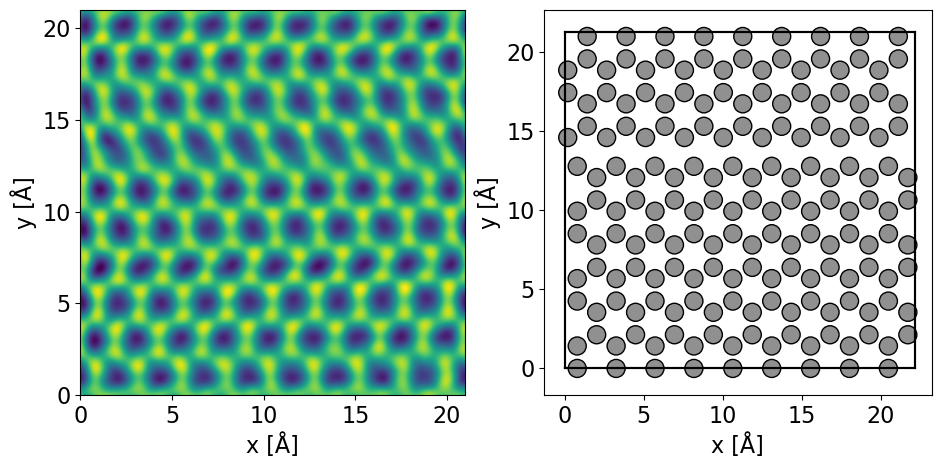

In [44]:
# Visualize one image and the corresponding model as an example.
dt = 33.3
ang = 36
thinR = 1
rpix = 512
qpix = 192
binQ = 16

dire = "/home/jupyter-toma/git/arina-ptycho/"
    
name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
path = dire + "results/" + name

res = np.load(path + ".npz")
    
original = res['ssb'].copy()

from abtem.visualize import show_atoms

if ang == 109 and binQ >= 4:
    atoms = orthogonalize_cell(structure)*(9,6,1)
    atoms.translate((0.6,-0.6,0))
    atoms.wrap()
    del atoms[[atom.index for atom in atoms if atom.position[1] > 23.5]]
    atoms.cell[1] = [0, 23.8, 0]
    atoms.set_cell(atoms.cell/1.04, scale_atoms=True)

elif ang == 109 and binQ < 4:
    atoms = orthogonalize_cell(structure)*(9,5,1)
    atoms.translate((0.8,1.4,0))
    atoms.wrap()

elif ang == 36 and dt == 10.0:
    atoms = orthogonalize_cell(structure)*(9,5,1)
    atoms.translate((0.5,1.4,0))
    atoms.wrap()
    if binQ == 1:
        atoms.translate((0.3,-0.4,0))
#        atoms.wrap()
    elif binQ == 16:
        atoms.set_cell(atoms.cell/1.04, scale_atoms=False)
        atoms.translate((-0.3,-0.2,0))
        
else:
    atoms = orthogonalize_cell(structure)*(9,5,1)
    for index in [atom.index for atom in atoms if atom.position[1]>14]:
        atoms[index].position+=[-0.6,0.4,0]
    atoms.translate((0.8,0.0,0))
    atoms.wrap()
    if thinR >= 4:
        atoms.set_cell(atoms.cell*1.02, scale_atoms=False)
        if thinR == 8:
            atoms.translate((-0.2,0.0,0))
            atoms.set_cell(atoms.cell/1.01, scale_atoms=True)
        
p = 0.15
selected_atoms = ((atoms.positions[:,0]>atoms.cell[0,0]*p)*(atoms.positions[:,0]<atoms.cell[0,0]*(1-p))*
                  (atoms.positions[:,1]>atoms.cell[1,1]*p)*(atoms.positions[:,1]<atoms.cell[1,1]*(1-p)))

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(11,5))
ax1.imshow(original, origin='lower', extent=(0,21,0,21))
ax1.set_xlabel("x [Å]")
ax1.set_ylabel("y [Å]")
show_atoms(atoms,ax=ax2);
plt.show()

In [25]:
import json
rawname = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_" + str(qpix) + "qpx"
rawpath = dire + "raw_data/" + rawname
me = json.load(open(rawpath + '.json'))

images = make_images_ctf(res)

rounds = [20, 20, 20, 20, 20, 20, 20]
modelsexp = batch_optimize_parallel_ctf(images, 4, atoms, me, rounds)

100%|██████████| 20/20 [09:47<00:00, 29.36s/it]


#### Making the optimization figure

In [28]:
import abtem

# Using abTEM functions to color in excluded area.
potential = abtem.Potential(atoms)
grid_scan1 = abtem.GridScan(
    start=[0, 0],
    end=[0.15, 1],
    fractional=True,
    potential=potential,
)

grid_scan2 = abtem.GridScan(
    start=[0.85, 0],
    end=[1.0, 1],
    fractional=True,
    potential=potential,
)

grid_scan3 = abtem.GridScan(
    start=[0, 0],
    end=[1, 0.15],
    fractional=True,
    potential=potential,
)

grid_scan4 = abtem.GridScan(
    start=[0, 0.85],
    end=[1, 1],
    fractional=True,
    potential=potential,
)

/tmp/ipykernel_1187080/3651901096.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


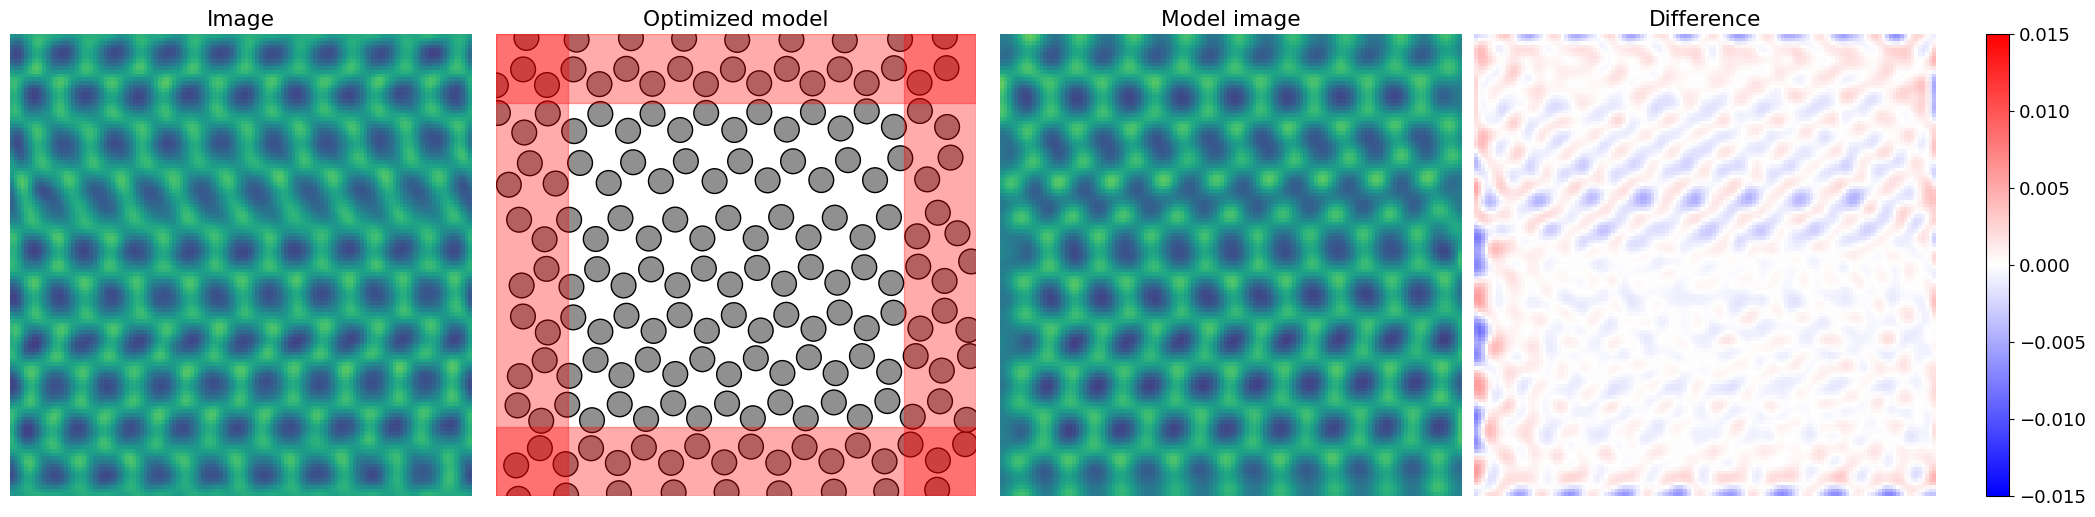

In [29]:
# Choose SSB
mod = modelsexp[0]
# Match the mean and standard deviation of simulation image
mod.match_mean_and_std()

plt.rcParams.update({'font.size': 13})
vmin = -0.015
vmax = 0.015
    
# Visualize the optimization result for one model as an example.
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(32,6),
                                  gridspec_kw={'wspace':-0.6,'width_ratios': [1,1,1,0.85]})

# check contrasts
im1 = ax1.imshow(np.flipud(mod.image), vmin=vmin, vmax=vmax)
show_atoms(mod.ase, ax=ax2, tight_limits=True)
grid_scan1.add_to_plot(ax2)
grid_scan2.add_to_plot(ax2)
grid_scan3.add_to_plot(ax2)
grid_scan4.add_to_plot(ax2)

im3 = ax3.imshow(np.flipud(mod.simulation), vmin=vmin, vmax=vmax)
im4 = ax4.imshow(np.flipud(mod.diffimage), vmin=vmin, vmax=vmax, cmap = 'bwr')

fig.colorbar(im4, ax=ax4)
ax1.axis('off')
ax1.set_title('Image')
ax2.axis('off')
ax2.set_title('Optimized model')
ax3.axis('off')
ax3.set_title('Model image')
ax4.axis('off')
ax4.set_title('Difference')
#plt.show()
plt.tight_layout()
plt.savefig(dire + "results/analyses/" + name + "_optresult_ssb.pdf", dpi=600)

In [45]:
plot_histo(modelsexp, atoms, relative=False, name=name)
plot_histo(modelsexp, atoms, relative=True, name=name)
plot_errors(modelsexp, name)

### Process in batches

In [3]:
import json

names = ["ssb", "ssb_ac", "wdd", "wdd_ac", "icom", "par", "iterGD"]
    
conv_angle = 0.034 #rad
energy = 60000 #eV
blur = 0

# Lattice constant and perpendicular cell size.
lc = 2.46
vac = 12.0

structure = Graphene(symbol='C', latticeconstant={'a':lc, 'c':vac},
                      size=(1,1,1))
structure.pbc = True

In [4]:
atoms = orthogonalize_cell(structure)*(9,5,1)
atoms.translate((0.9,0.2,0))
atoms.wrap()

dt = 33.3
ang = 36
thinR = 1
rpix = 512
qpix = 192

for binQ in [32, 16, 8, 4, 2, 1]:
    if binQ == 2:
        atoms.set_cell(atoms.cell/1.02, scale_atoms=False)

    rawname = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_" + str(qpix) + "qpx"
    rawpath = dire + "raw_data/" + rawname

    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
    path = dire + "results/" + name

    res = np.load(path + ".npz")
    me = json.load(open(rawpath + '.json'))

    images = make_images_ctf(res)

    rounds = [20, 20, 20, 20, 60, 20, 40]
    modelsexp = batch_optimize_parallel_ctf(images, 4, atoms, me, rounds)

    for i in range(7):
        write(dire + 'results/analyses/' + name + '_' + names[i] + '_model.xyz', modelsexp[i].ase)
        np.save(dire + 'results/analyses/' + name + '_' + names[i] + '_model.parameters', modelsexp[i].get_parameters(), allow_pickle=True)

    plot_errors(modelsexp, name)

    plot_histo(modelsexp, atoms, False, name)
    plot_histo(modelsexp, atoms, True, name)

100%|██████████| 60/60 [26:09<00:00, 26.15s/it]
/home/jupyter-toma/git/stem_optimization/Model.py:125: RuntimeWarning: invalid value encountered in divide
  self.intensities=self.intensities/np.nanmean(self.intensities)*np.nanstd(self.image)


ValueError: autodetected range of [nan, nan] is not finite

In [8]:
atoms = orthogonalize_cell(structure)*(9,5,1)
atoms.translate((0.5,1.4,0))
atoms.wrap()

dt = 10.0
ang = 36
thinR = 1
rpix = 512
qpix = 96

for binQ in [16,8,4,2,1]:

    if binQ == 1:
        atoms.translate((0.3,-0.4,0))

    rawname = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_" + str(qpix) + "qpx"
    rawpath = dire + "raw_data/" + rawname

    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
    path = dire + "results/" + name

    res = np.load(path + ".npz")
    me = json.load(open(rawpath + '.json'))

    images = make_images_ctf(res)

    if binQ >= 4:
        rounds = [20, 20, 20, 20, 60, 20, 80]
    else:
        rounds = [20, 20, 20, 20, 60, 20, 60]

    modelsexp = batch_optimize_parallel_ctf(images, 4, atoms, me, rounds)

    for i in range(7):
        write(dire + 'results/analyses/' + name + '_' + names[i] + '_model.xyz', modelsexp[i].ase)

        np.save(dire + 'results/analyses/' + name + '_' + names[i] + '_model.parameters', modelsexp[i].get_parameters(),allow_pickle=True)

    plot_errors(modelsexp, name)

    plot_histo(modelsexp, atoms, False, name)
    plot_histo(modelsexp, atoms, True, name)

100%|██████████| 60/60 [26:54<00:00, 26.91s/it]


No data for parallax.


/home/jupyter-toma/git/stem_optimization/Model.py:125: RuntimeWarning: invalid value encountered in divide
  self.intensities=self.intensities/np.nanmean(self.intensities)*np.nanstd(self.image)


In [9]:
atoms = orthogonalize_cell(structure)*(9,5,1)
atoms.translate((0.5,0.3,0))
atoms.wrap()
atoms.set_cell(atoms.cell/1.02, scale_atoms=False)

dt = 33.3
ang = 36
binQ = 16
rpix = 512
qpix = 192

for thinR in [8, 4, 2]:
    if thinR >= 4:
        atoms.set_cell(atoms.cell*1.02, scale_atoms=False)
        if thinR == 8:
            atoms.translate((-0.2,0.0,0))
            atoms.set_cell(atoms.cell/1.01, scale_atoms=True)

    rawname = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_" + str(qpix) + "qpx"
    rawpath = dire + "raw_data/" + rawname

    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
    path = dire + "results/" + name

    res = np.load(path + ".npz")
    me = json.load(open(rawpath + '.json'))

    images = make_images_ctf(res)

    rounds = [20, 20, 20, 20, 60, 20, 20]

    if thinR == 2:
        modelsexp = batch_optimize_parallel_ctf(images, 2, atoms, me, rounds)
    elif thinR >= 4:
        modelsexp = batch_optimize_parallel_ctf(images, 1, atoms, me, rounds)

    for i in range(7):
        write(dire + 'results/analyses/' + name + '_' + names[i] + '_model.xyz', modelsexp[i].ase)
        np.save(dire + 'results/analyses/' + name + '_' + names[i] + '_model.parameters', modelsexp[i].get_parameters(),allow_pickle=True)

    plot_errors(modelsexp, name)

    plot_histo(modelsexp, atoms, False, name)
    plot_histo(modelsexp, atoms, True, name)

100%|██████████| 60/60 [26:26<00:00, 26.43s/it]


In [46]:
dt = 100
ang = 109
thinR = 1
rpix = 256
qpix = 192

for binQ in [8, 4, 2, 1]:
    if ang == 109 and binQ >= 4:
        atoms = orthogonalize_cell(structure)*(9,6,1)
        atoms.translate((0.6,-0.6,0))
        atoms.wrap()
        del atoms[[atom.index for atom in atoms if atom.position[1] > 23.5]]
        atoms.cell[1] = [0, 23.8, 0]
        atoms.set_cell(atoms.cell/1.04, scale_atoms=True)

    elif ang == 109 and binQ < 4:
        atoms = orthogonalize_cell(structure)*(9,5,1)
        atoms.translate((0.8,1.4,0))
        atoms.wrap()
    
    rawname = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_" + str(qpix) + "qpx"
    rawpath = dire + "raw_data/" + rawname

    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
    path = dire + "results/" + name

    res = np.load(path + ".npz")
    me = json.load(open(rawpath + '.json'))

    images = make_images_ctf(res)

    rounds = [20, 20, 20, 20, 80, 30, 80]
    modelsexp = batch_optimize_parallel_ctf(images, 4, atoms, me, rounds)

    for i in range(7):
        try:
            write(dire + 'results/analyses/' + name + '_' + names[i] + '_model.xyz', modelsexp[i].ase)
            np.save(dire + 'results/analyses/' + name + '_' + names[i] + '_model.parameters', modelsexp[i].get_parameters(),allow_pickle=True)
        except:
            print("No model found.")

    plot_errors(modelsexp, name)

    plot_histo(modelsexp, atoms, False, name)
    plot_histo(modelsexp, atoms, True, name)

100%|██████████| 80/80 [20:17<00:00, 15.22s/it]


## Analyze fitted phases

In [36]:
import matplotlib.pyplot as plt
import numpy as np
names = ["SSB", "SSB (AC)", "WDD", "WDD (AC)", "iCOM", "Parallax", "Iterative GD"]
dire = "/home/jupyter-toma/git/arina-ptycho/"

plt.rcParams.update({'font.size': 10})

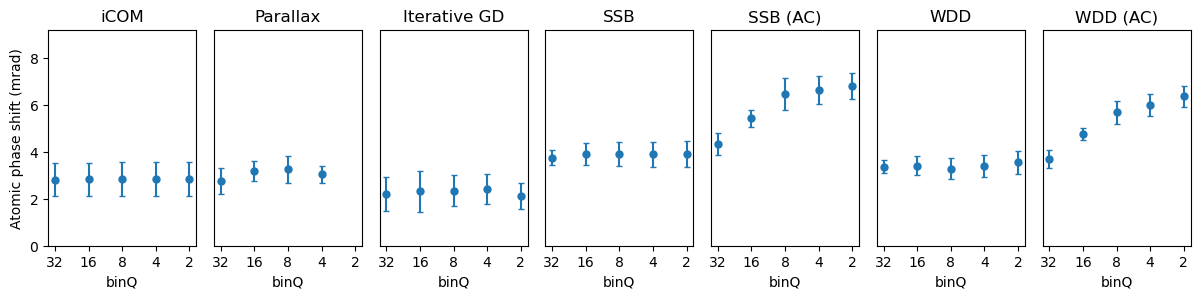

In [37]:
dt = 33.3
ang = 36
thinR = 1
rpix = 512
qpix = 192

binQ = [32, 16, 8, 4, 2]

bQs = []
for bQ in binQ:
    bQs.append(str(bQ))

means = np.empty((len(binQ),7))
errors = np.empty((len(binQ),7))

for i in range(len(binQ)):
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ[i])
    path = dire + "results/analyses/" + name

    phases = np.loadtxt(path + "_phases.txt")
    
    means[i] = phases[::2]
    errors[i] = phases[1::2]*1.96 #95% confidence interval

fig, axs = plt.subplots(1, 7, figsize=(12,3), gridspec_kw={'wspace':0.12, 'left':0.038, 'right':0.99, 'bottom':0.16})

axs[0].set_ylabel("Atomic phase shift (mrad)");

for i in range(3):
    axs[i].set_title(names[i-3])
    axs[i].errorbar(bQs, means[:,i-3], errors[:,i-3], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i].set_xlabel("binQ")
for i in range(4):
    axs[i+3].set_title(names[i])
    axs[i+3].errorbar(bQs, means[:,i], errors[:,i], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i+3].set_xlabel("binQ")  

for ax in axs:
    ax.set_ylim((0,9.2))

for ax in axs[1:]:
    ax.set_yticks([])

#plt.savefig(dire + "results/analyses/res" + str(ang) + "mrad_full_binQ_phaseplots.pdf")

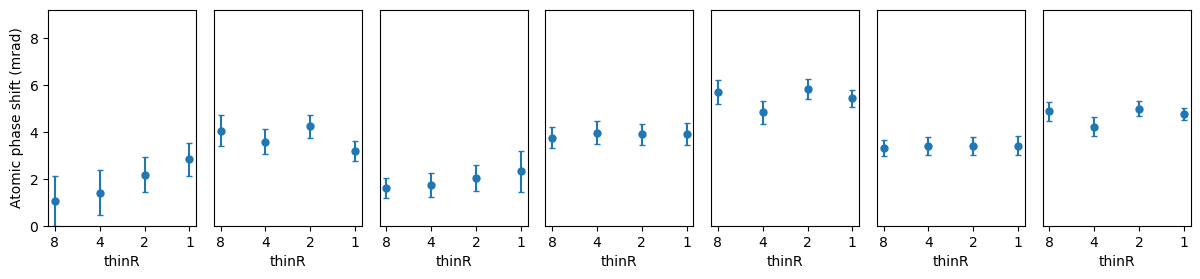

In [20]:
dt = 33.3
ang = 36
binQ = 16
rpix = 512
qpix = 192

thinR = [8, 4, 2, 1]

tRs = []
for tR in thinR:
    tRs.append(str(tR))

means = np.empty((len(thinR),7))
errors = np.empty((len(thinR),7))

for i in range(len(thinR)):
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR[i]) + "_" + str(qpix) + "qpx_bQ" + str(binQ)
    path = dire + "results/analyses/" + name

    phases = np.loadtxt(path + "_phases.txt")
    
    means[i] = phases[::2]
    errors[i] = phases[1::2]*1.96 #95% confidence interval

fig, axs = plt.subplots(1, 7, figsize=(12,3), gridspec_kw={'wspace':0.12, 'left':0.038, 'right':0.99, 'bottom':0.16})

axs[0].set_ylabel("Atomic phase shift (mrad)");

for i in range(3):
    #axs[i].set_title(names[i-3])
    axs[i].errorbar(tRs, means[:,i-3], errors[:,i-3], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i].set_xlabel("thinR")
for i in range(4):
    #axs[i+3].set_title(names[i])
    axs[i+3].errorbar(tRs, means[:,i], errors[:,i], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i+3].set_xlabel("thinR")  

for ax in axs:
    ax.set_ylim((0,9.2))
    
for ax in axs[1:]:
    ax.set_yticks([])

#plt.savefig(dire + "results/analyses/res" + str(ang) + "mrad_full_thinR_phaseplots.pdf")

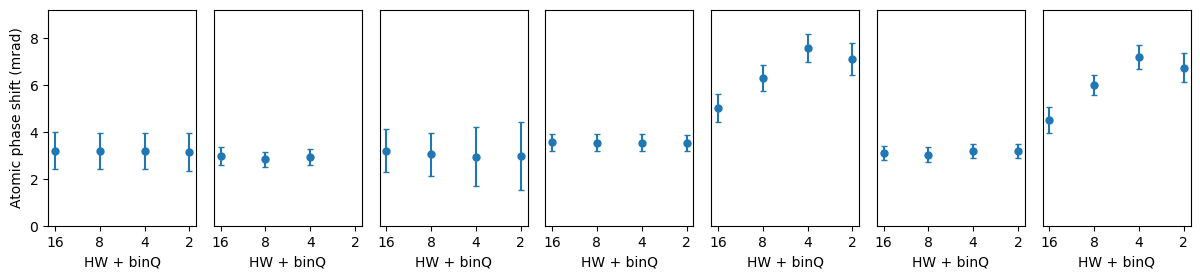

In [35]:
dt = 10.0
ang = 36
binQ = 1
thinR = 1
rpix = 512
qpix = 96

binQ = [16, 8, 4, 2, 1]
bQs = []
for bQ in binQ:
    bQs.append(str(bQ))

means = np.empty((len(binQ),7))
errors = np.empty((len(binQ),7))

for i in range(len(binQ)-1):
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ[i+1])
    path = dire + "results/analyses/" + name

    phases = np.loadtxt(path + "_phases.txt")
    
    means[i] = phases[::2]
    errors[i] = phases[1::2]*1.96 #95% confidence interval

fig, axs = plt.subplots(1, 7, figsize=(12,3), gridspec_kw={'wspace':0.12, 'left':0.038, 'right':0.99, 'bottom':0.16})

axs[0].set_ylabel("Atomic phase shift (mrad)");

for i in range(3):
    #axs[i].set_title(names[i-3])
    axs[i].errorbar(bQs, means[:,i-3], errors[:,i-3], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i].set_xlabel("HW + binQ")
for i in range(4):
    #axs[i+3].set_title(names[i])
    axs[i+3].errorbar(bQs, means[:,i], errors[:,i], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i+3].set_xlabel("HW + binQ")  

for ax in axs:
    ax.set_xlim([-0.15,3.15])
    ax.set_ylim((0,9.2))
    
for ax in axs[1:]:
    ax.set_yticks([])
    
#plt.savefig(dire + "results/analyses/res" + str(ang) + "mrad_fast_binQ_phaseplots.pdf")

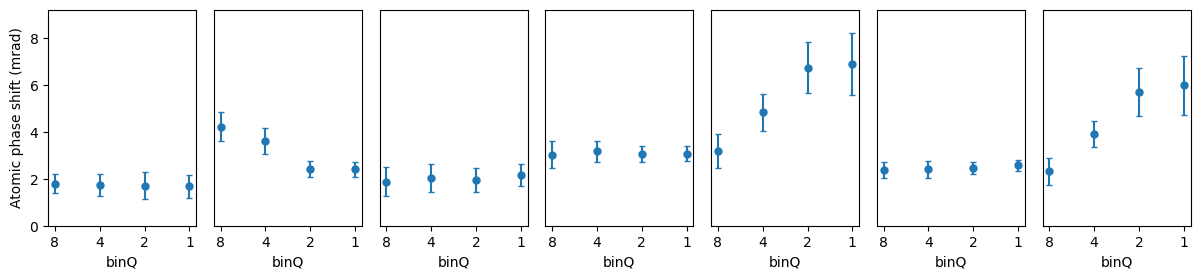

In [34]:
dt = 100
ang = 109
thinR = 1
rpix = 256
qpix = 192

binQ = [8, 4, 2, 1]

bQs = []
for bQ in binQ:
    bQs.append(str(bQ))

means = np.empty((len(binQ),7))
errors = np.empty((len(binQ),7))

for i in range(len(binQ)):
    
    name = "res" + str(ang) + "mrad_" + str(dt) + "us_" + str(rpix) + "rpx_tR" + str(thinR) + "_" + str(qpix) + "qpx_bQ" + str(binQ[i])
    path = dire + "results/analyses/" + name

    phases = np.loadtxt(path + "_phases.txt")
    
    means[i] = phases[::2]
    errors[i] = phases[1::2]*1.96 #95% confidence interval

fig, axs = plt.subplots(1, 7, figsize=(12,3), gridspec_kw={'wspace':0.12, 'left':0.038, 'right':0.99, 'bottom':0.16})

axs[0].set_ylabel("Atomic phase shift (mrad)");

for i in range(3):
    #axs[i].set_title(names[i-3])
    axs[i].errorbar(bQs, means[:,i-3], errors[:,i-3], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i].set_xlabel("binQ")
for i in range(4):
    #axs[i+3].set_title(names[i])
    axs[i+3].errorbar(bQs, means[:,i], errors[:,i], capsize=2, marker='o', markersize=5, linestyle='none')#, ax=axs[0])
    axs[i+3].set_xlabel("binQ")  

for ax in axs:
    ax.set_ylim((0,9.2))
    
        
for ax in axs[1:]:
    ax.set_yticks([])

#plt.savefig(dire + "results/analyses/res" + str(ang) + "mrad_long_binQ_phaseplots.pdf")